# plot zonal sections from CESM and CMIP5

In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import colorbrewer
import plot_tools
import proc_cesm_le

In [2]:
%%time
varlist = ['O2','AOU'] #,'TEMP']

op = 'ann_dft_za'
tr85 = proc_cesm_le.open_ens('tr85',op,varlist,isel={'basins':0})
tr45 = proc_cesm_le.open_ens('tr45',op,varlist,isel={'basins':0})

v = 'O2sat'
tr85[v] = tr85['AOU'] + tr85['O2']
tr45[v] = tr45['AOU'] + tr45['O2']
varlist.append(v)  
print tr85

<xarray.Dataset>
Dimensions:      (ens: 33, lat_t: 394, lat_t_edges: 395, time: 182, z_t: 60)
Coordinates:
  * lat_t        (lat_t) float64 -79.22 -78.69 -78.15 -77.62 -77.08 -76.55 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * lat_t_edges  (lat_t_edges) float32 -79.4871 -78.9529 -78.4187 -77.8844 ...
Dimensions without coordinates: ens, time
Data variables:
    O2           (ens, time, z_t, lat_t) float64 nan nan 344.2 341.4 337.1 ...
    AOU          (ens, time, z_t, lat_t) float64 nan nan 28.65 31.9 35.52 ...
    O2sat        (ens, time, z_t, lat_t) float64 nan nan 372.9 373.3 372.7 ...
CPU times: user 1.35 s, sys: 658 ms, total: 2.01 s
Wall time: 24.8 s


In [3]:
%%time
tr85a = tr85.mean(dim='ens')
tr45a = tr45.mean(dim='ens')
print tr85a

/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:      (lat_t: 394, lat_t_edges: 395, time: 182, z_t: 60)
Coordinates:
  * lat_t        (lat_t) float64 -79.22 -78.69 -78.15 -77.62 -77.08 -76.55 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * lat_t_edges  (lat_t_edges) float32 -79.4871 -78.9529 -78.4187 -77.8844 ...
Dimensions without coordinates: time
Data variables:
    O2           (time, z_t, lat_t) float64 nan nan 344.2 341.4 337.1 340.0 ...
    AOU          (time, z_t, lat_t) float64 nan nan 28.65 31.9 35.52 33.52 ...
    O2sat        (time, z_t, lat_t) float64 nan nan 372.9 373.3 372.7 373.5 ...
CPU times: user 458 ms, sys: 243 ms, total: 701 ms
Wall time: 350 ms


In [4]:
tr85a = tr85a.compute()
tr45a = tr45a.compute()

In [5]:
ds_za = xr.merge((xr.open_dataset('data/IUCN_O2zon_2100.nc'),
                  xr.open_dataset('data/IUCN_AOUzon_2100.nc')))

ds_za['O2'] = ds_za.DO2
ds_za['AOU'] = ds_za.DAOU
v = 'O2sat'
ds_za[v] = ds_za['AOU'] + ds_za['O2']
ds_za

<xarray.Dataset>
Dimensions:   (LAT: 180, LEV: 33, bnds: 2)
Coordinates:
  * LAT       (LAT) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * LEV       (LEV) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
Dimensions without coordinates: bnds
Data variables:
    LEV_bnds  (LEV, bnds) float64 -5.0 5.0 5.0 15.0 15.0 25.0 25.0 40.0 40.0 ...
    DO2       (LEV, LAT) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    DAOU      (LEV, LAT) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    O2        (LEV, LAT) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    AOU       (LEV, LAT) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    O2sat     (LEV, LAT) float64 nan nan nan nan nan nan nan nan nan nan nan ...

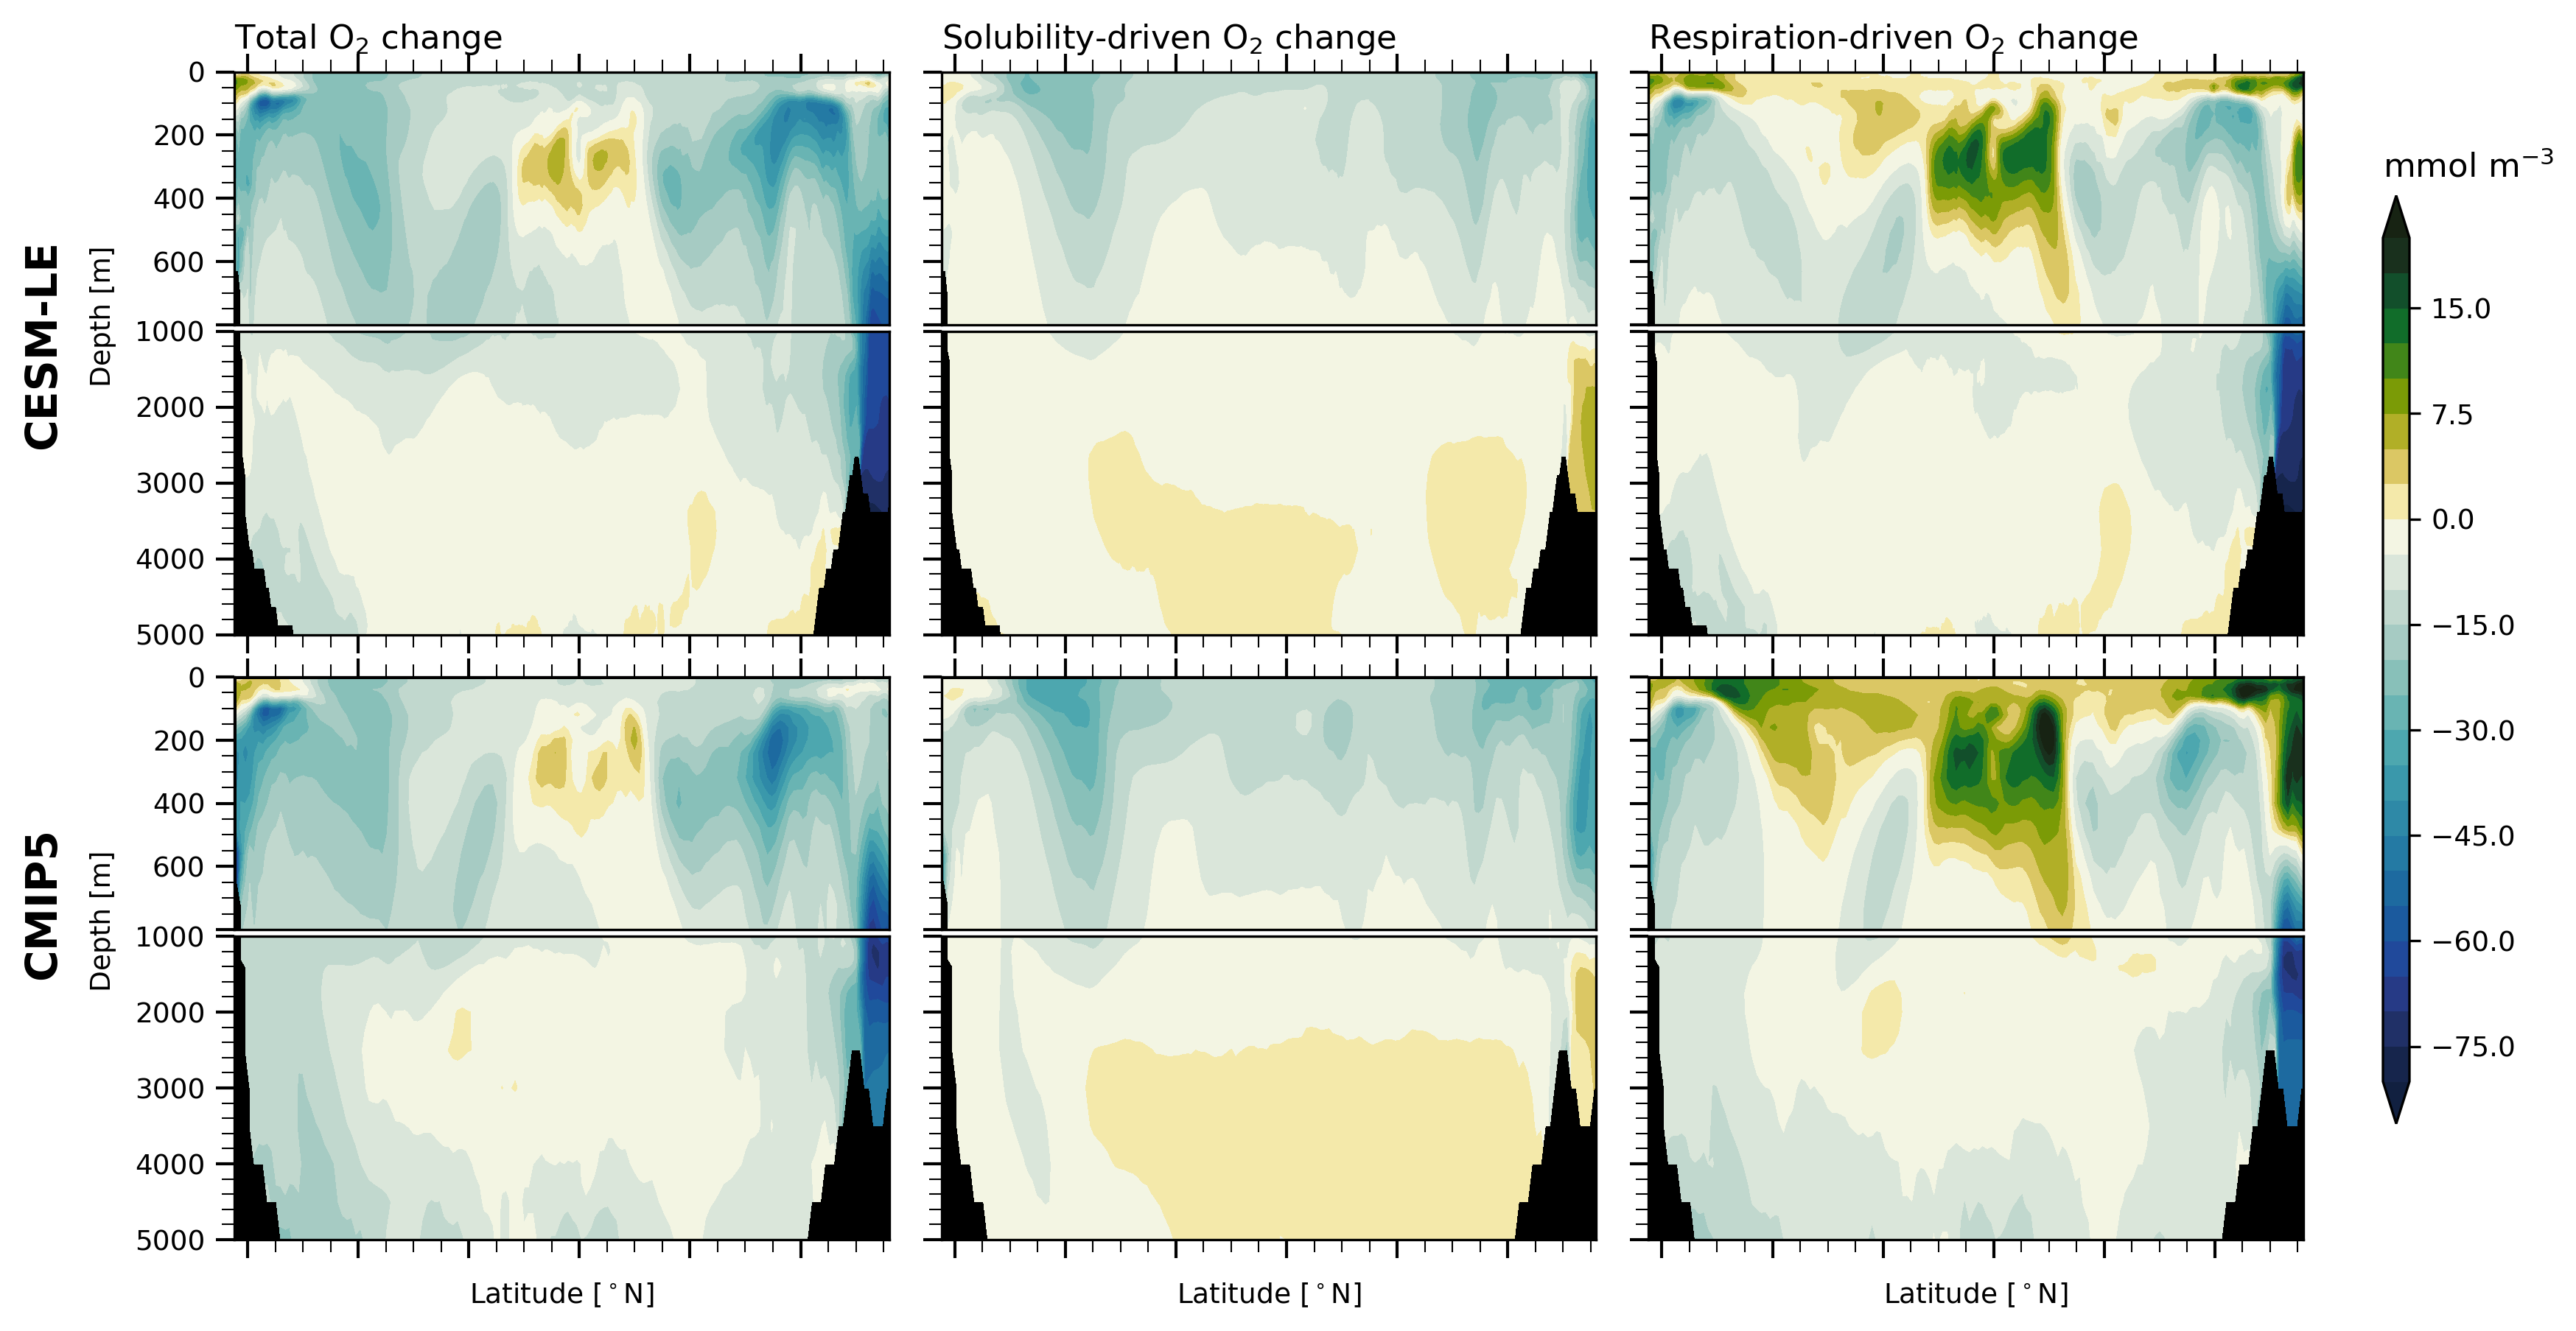

In [6]:
reload(plot_tools)
plot_name = os.path.join(diro['fig'],'global-zonal-mean-O2-AOU-O2sat.pdf')

fig = plt.figure(dpi=300,figsize=(12,7))

gs = gridspec.GridSpec(2,3)

levels = np.concatenate((np.arange(-80.,0.,5.),np.arange(0.,22.5,2.5)))
norm = plot_tools.MidPointNorm(midpoint=0.)
contour_specs = {'levels':levels,'cmap':cmocean.cm.delta,'norm':norm,'extend':'both'}


lat = tr85a['lat_t']
depth = tr85a['z_t']/100.

obj = {}
for i,v in enumerate(['O2','O2sat','AOU']):
    baseline = tr85a[v][0:20,:].mean(dim='time')
    field = tr85a[v][-1,:,:] - baseline[:,:]

    if v == 'AOU':
        field = -1.*field

    obj[v] = plot_tools.canvas_full_depth_section(lat,depth,field,
                                       fig = fig,
                                       gridspec_spec = gs,
                                       row = 0, col = i,
                                       contour_specs = contour_specs,
                                       xlim = [-78,70])

    if i > 0:
        [ax.set_yticklabels([]) for ax in obj[v]['ax']]
        [ax.set_ylabel('') for ax in obj[v]['ax']]
    [ax.set_xticklabels([]) for ax in obj[v]['ax']]
    [ax.set_xlabel('') for ax in obj[v]['ax']]
        
lat = ds_za['LAT']
depth = ds_za['LEV']

for i,v in enumerate(['O2','O2sat','AOU']):
    
    field = ds_za[v][:,:]

    if v == 'AOU':
        field = -1.*field

    obj[v+'cmip'] = plot_tools.canvas_full_depth_section(lat,depth,field,
                                       fig = fig,
                                       gridspec_spec = gs,
                                       row = 1, col = i,
                                       contour_specs = contour_specs,
                                       xlim = [-78,70])

    if i > 0:
        [ax.set_yticklabels([]) for ax in obj[v+'cmip']['ax']]
        [ax.set_ylabel('') for ax in obj[v+'cmip']['ax']]
        
        
gs.update(left=0.11, right=0.89, wspace=0.08,hspace=0.075)
cbaxes = fig.add_axes([0.92, 0.2, 0.01, 0.6])
cb = fig.colorbar(obj['O2']['cf'][0], cax=cbaxes)
cbaxes.set_title('mmol m$^{-3}$',loc='left')

obj['O2']['ax'][0].set_title('Total O$_2$ change',loc='left',y=1.02)
obj['O2sat']['ax'][0].set_title('Solubility-driven O$_2$ change',loc='left',y=1.02)
obj['AOU']['ax'][0].set_title('Respiration-driven O$_2$ change',loc='left',y=1.02)

fig.text(0.03,0.75,'CESM-LE',
         fontsize=14.,
         fontweight = 'semibold',rotation=90)

fig.text(0.03,0.37,'CMIP5',
         fontsize=14.,
         fontweight = 'semibold',rotation=90)

plt.savefig(plot_name,dpi=300,bbox_inches='tight')